# CS4248 Project Group 23

In [1]:
# If you wish to run this on Google Colab, mount the Google drive by running this cell or click the `files` icon on the left navbar
# and click mount Google Drive (it takes some time to load)
# from google.colab import drive
# drive.mount('/content/drive')

# %cd "/content/drive/My Drive/CS4248_BERT.ipynb"
# !cd "/content/drive/My Drive/CS4248_BERT.ipynb"

In [2]:
# To check if torch is working on m1
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

MPS device not found.


In [3]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np

In [4]:
from transformers import BertTokenizer
train = pd.read_csv("/content/drive/MyDrive/raw_data/fulltrain.csv", names=['Verdict', 'Text'])

seq_len = 512
num_samples = len(train)
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))    #attention mask
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, text in enumerate(train['Text']):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

ModuleNotFoundError: No module named 'transformers'

In [ ]:
Xids

array([[  101.,   138.,  1376., ...,     0.,     0.,     0.],
       [  101.,  1109.,  5094., ...,     0.,     0.,     0.],
       [  101.,  2711.,  3711., ...,   170.,  2156.,   102.],
       ...,
       [  101.,  1697.,  7085., ...,  7699., 14604.,   102.],
       [  101.,  1109.,  2073., ...,     0.,     0.,     0.],
       [  101.,  1109.,  3424., ...,     0.,     0.,     0.]])

In [1]:
y_train = train['Verdict'].values - 1 # subtract 1 to make the labels 0-based
y_labels = np.zeros((num_samples, y_train.max()+1))
y_labels[np.arange(num_samples), y_train] = 1   #one-hot encoding of the labels

NameError: name 'train' is not defined

In [ ]:
print(y_labels)
print(y_labels.shape)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
(48854, 4)


In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels    #create a tuple of dictionaries

dataset = dataset.map(map_func)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True) #shuffle the data, then batch it and drop remainder if any
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>

In [ ]:
split = 0.9
size = int((num_samples / batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

Test out different kinds of models and find the most effective architectures.|

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-uncased')
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
!pip show transformers

Name: transformers
Version: 4.39.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
#input layers with the shape of seq_len
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# create embeddings from bert
embeddings = bert.bert(input_ids, attention_mask=mask)[1]   #extracting the pooled layer of 3D tensors pulled into 2D

x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(y_train.max()+1, activation='softmax', name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable=False   #freeze the training of the bert layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6)
# loss = tf.keras.losses.CategoricalCrossentropy()
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=[tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1_score', dtype=None)])

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)

Epoch 1/3
2748/2748 [==============================] - 2288s 817ms/step - loss: 0.7132 - accuracy: 0.6948 - val_loss: 0.7147 - val_accuracy: 0.7125
Epoch 2/3
2748/2748 [==============================] - 2248s 818ms/step - loss: 0.6594 - accuracy: 0.7190 - val_loss: 0.6925 - val_accuracy: 0.6990
Epoch 3/3
2748/2748 [==============================] - 2248s 818ms/step - loss: 0.6253 - accuracy: 0.7396 - val_loss: 0.6528 - val_accuracy: 0.7494


In [ ]:
model.save('BERT_Model')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


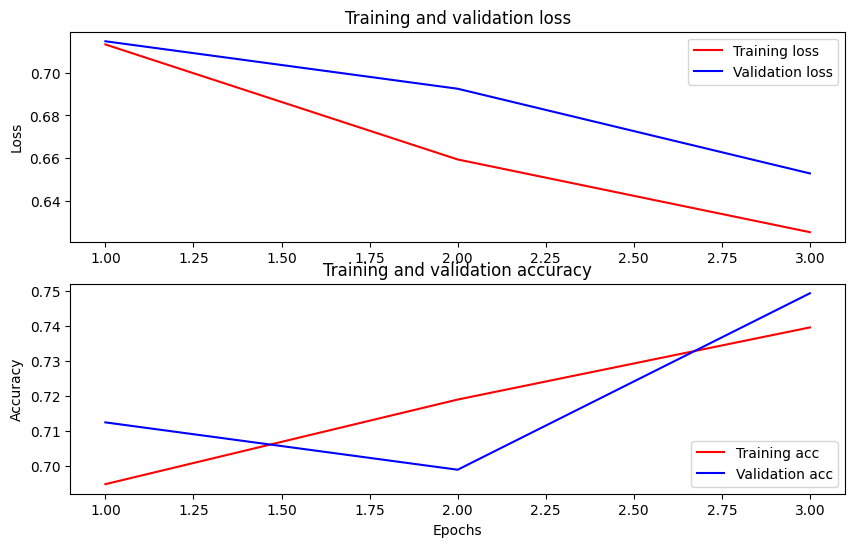

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Testing

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/raw_data/balancedtest.csv")
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def preprocess_text(text):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')

    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
    }

In [ ]:
for text in test.iloc[:, 1]:
    test = preprocess_text(text)
    probs = model.predict(test)
    y_pred = np.array(np.argmax(probs[0]))

<class 'numpy.ndarray'>
[0 0 0 ... 3 3 3]


In [1]:
y_test = test.iloc[:, 0].values - 1 # subtract 1 to make the labels 0-based

# get the f1 score
f1_score_test = f1_score(y_test, y_pred, average='macro')
print(f1_score_test)

NameError: name 'test' is not defined

References: \
James Briggs: https://www.youtube.com/watch?v=pjtnkCGElcE\
Tensor Flow Documentation: https://www.tensorflow.org/text/tutorials/classify_text_with_bert